In [1]:
!pip install scikit-image opencv-python scikit-learn matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/EAFIT/Semestre3/Visualizacion_de_datos/Talleres/mango_leaf_disease'

# Cargar imágenes y etiquetas

In [4]:
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np



#data_dir = "EAFIT/Semestre3/Visualizacion_de_datos/Talleres/mango_leaf_disease/"
image_size = (128, 128)  # Tamaño estándar

X, y = [], []
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = imread(img_path, as_gray=True)
            img = resize(img, image_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

#Extraer características HOG

In [5]:
from skimage.feature import hog

features = []
for image in X:
    fd = hog(image, orientations=9, pixels_per_cell=(8, 8),
             cells_per_block=(2, 2), block_norm='L2-Hys')
    features.append(fd)

X_hog = np.array(features)

#Entrenamiento del modelo SVM

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)

# Grilla reducida
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']  # solo aplica si kernel es 'rbf'
}

# Grid Search
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))


Mejores parámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8225
F1-Score: 0.8233415868522747


#Visualización de predicciones

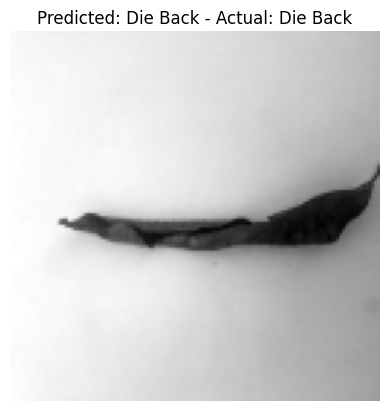

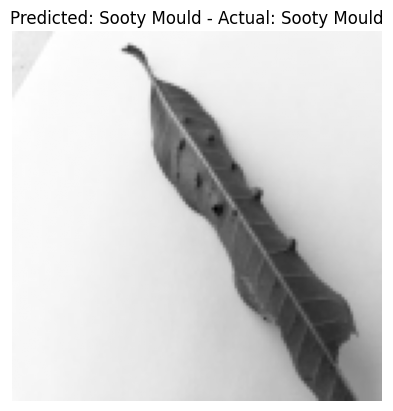

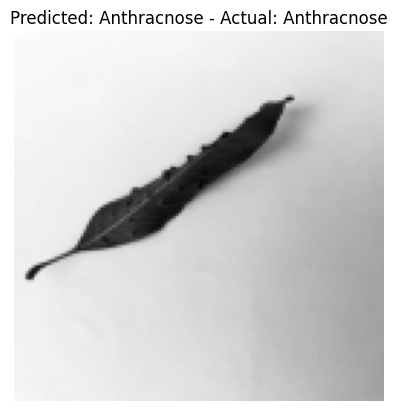

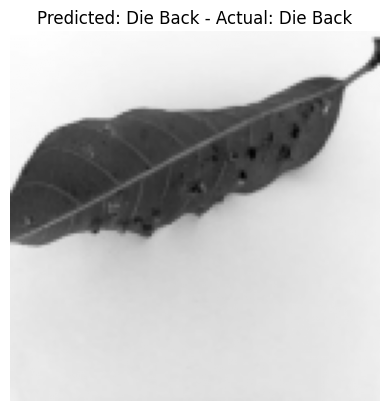

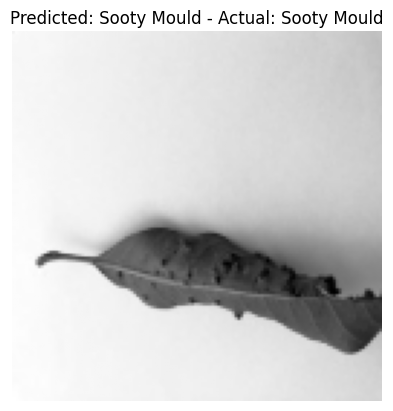

In [7]:
import matplotlib.pyplot as plt
import random

for _ in range(5):
    idx = random.randint(0, len(y_test)-1)
    plt.imshow(X[idx], cmap='gray')
    plt.title(f"Predicted: {y_pred[idx]} - Actual: {y_test[idx]}")
    plt.axis('off')
    plt.show()


# Entrenamiento con Red Neuronal Simple (Keras)

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [9]:
#División y ajuste de los datos
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Datos 4D (N, W, H, C)
X_train_nn = X_train_nn[..., np.newaxis]
X_test_nn = X_test_nn[..., np.newaxis]


#Entrenamiento de la red

In [10]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_nn.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])



early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_nn, y_train_nn, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stop])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.1579 - loss: 2.0544 - val_accuracy: 0.4500 - val_loss: 1.5491
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 138s 989ms/step - accuracy: 0.4581 - loss: 1.4211 - val_accuracy: 0.5437 - val_loss: 1.1664
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5758 - loss: 1.1356 - val_accuracy: 0.6531 - val_loss: 0.9829
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 139s 969ms/step - accuracy: 0.6132 - loss: 0.9753 - val_accuracy: 0.7094 - val_loss: 0.8272
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7213 - loss: 0.7909 - val_accuracy: 0.7625 - val_loss: 0.7043
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7364 - loss: 0.6873 - val_accuracy: 0.7219 - val_loss: 0.7286
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7871 - loss: 0.5836 - val_accuracy: 0.7437 - val_loss: 0.7174
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8243 - loss: 0.4756 - val_accuracy: 0.815

#Evaluación

In [11]:
from sklearn.metrics import classification_report

y_pred_nn = model.predict(X_test_nn)
y_pred_labels = le.inverse_transform(np.argmax(y_pred_nn, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test_nn, axis=1))

print("📊 Neural Network Results:")
print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("F1 Score:", f1_score(y_true_labels, y_pred_labels, average='weighted'))


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step
📊 Neural Network Results:
Accuracy: 0.80375
F1 Score: 0.8008694828452215


#Visualización de datos

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


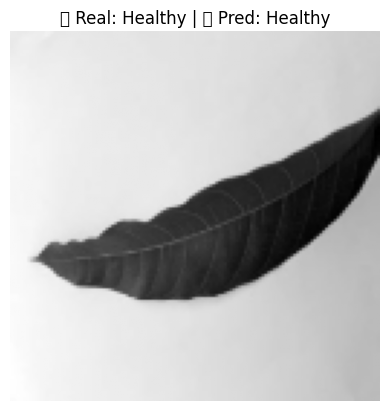

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


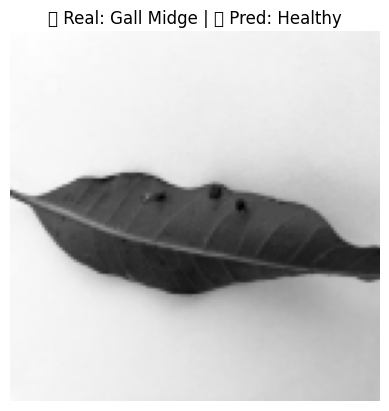

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


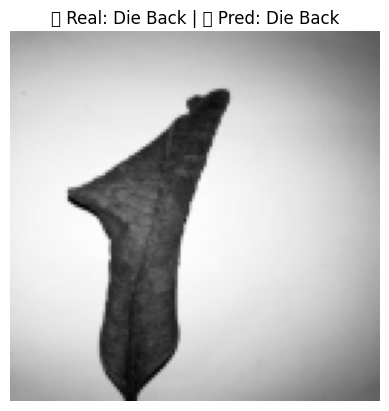

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


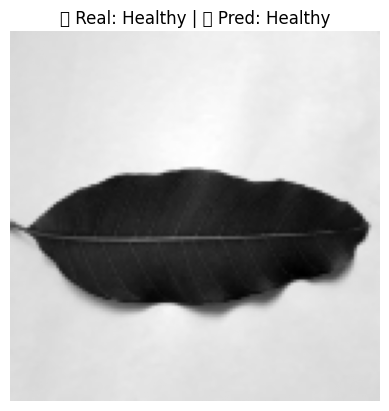

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


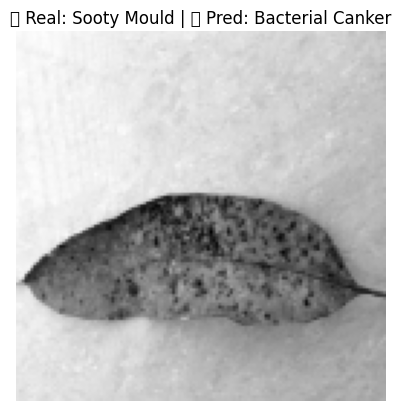

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Número de imágenes a mostrar
num_images = 5

# Índices aleatorios
indices = np.random.choice(len(X_test_nn), num_images, replace=False)

for i in indices:
    image = X_test_nn[i].squeeze()
    true_label = le.inverse_transform([np.argmax(y_test_nn[i])])[0]
    pred_label = le.inverse_transform([np.argmax(y_pred_nn[i])])[0]

    plt.imshow(image, cmap='gray')
    plt.title(f"✅ Real: {true_label} | 🤖 Pred: {pred_label}")
    plt.axis('off')
    plt.show()

# **Conclusiones del Taller**

**1. Comparación de enfoques Clásicos y Modernos**

Se exploraron dos enfoques clave para la clasificación de enfermedades en hojas de mango:

- Visión por computador clásica con extracción de características HOG + modelos tradicionales como SVM.

- Visión moderna con Deep Learning mediante una CNN construida desde cero.

**2. Resultados**

| Modelo                        | Accuracy   | F1 Score  | Observaciones                                                                   |
| ----------------------------- | ---------- | --------- | ------------------------------------------------------------------------------- |
| **SVM (lineal)**              | 0.76375    | 0.759     | Buen resultado inicial con HOG                                                  |
| **CNN (arquitectura simple)** | 0.68875    | 0.684     | Inferior al modelo clásico                                                      |
| **SVM (ajustado)**            | **0.8225** | **0.823** | Mejor resultado general tras optimización con `GridSearchCV`                    |
| **CNN (mejorada)**            | 0.80375    | 0.800     | Competitivo, mejora significativa con arquitectura más profunda y EarlyStopping |


**3. Análisis de desempeño**

- El modelo SVM con kernel RBF y C=10 superó a todas las configuraciones evaluadas. Esto resalta el poder de los clasificadores clásicos bien optimizados cuando se cuenta con un buen vector de características como HOG.

- La CNN mejorada, aunque inicialmente más débil, logró resultados competitivos tras optimizar su arquitectura, lo cual valida el potencial de enfoques basados en aprendizaje profundo, sobre todo cuando se tienen más datos y capacidad de cómputo.

- La combinación de HOG como método de extracción de características fue clave para el buen rendimiento del SVM, destacando su robustez frente a cambios en textura y forma.

